<img style="float: right;" src="http://www2.le.ac.uk/liscb1.jpg">  
# Leicester Institute of Structural and Chemical Biology: Python for Biochemists
# Analysis of Variants (ANOVA)
The two most popular python libraries for running ANOVA tests are *scipy* and *statsmodels*.  If you're only interested in one-way ANOVA, use scipy.  For more more complex analyses, use statsmodels.  

Just like the *t*-test (and virtually all other statistical tests,) ANOVA makes makes some assumptions:
* Each set of data is normally distributed
* The variances of each data set are the same
* The observations are independent  

ANOVA is fairly tolerant to violations of the Normality assumption, with the notable exception of distributions with very 'flat' peaks (this is quite rare, however.)

## One-way ANOVA
For consistency with R, we'll use the PlantGrowth dataset (which we import using `pandas`.  Running a one-way anova is as simple as calling `f_oneway` on your data.

In [1]:
import pandas as pd
df1 = pd.read_csv('../data/PlantGrowth.csv', index_col=0)
df1

,weight,group
1,4.17,ctrl
2,5.58,ctrl
3,5.18,ctrl
4,6.11,ctrl
5,4.50,ctrl
6,4.61,ctrl
7,5.17,ctrl
8,4.53,ctrl
9,5.33,ctrl
10,5.14,ctrl


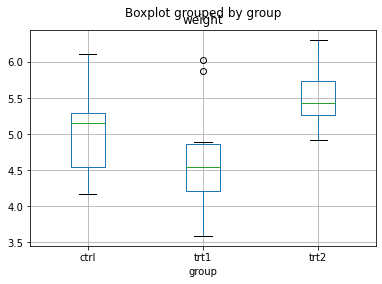

In [2]:
df1.boxplot('weight', by='group', figsize=(6, 4));

In [3]:
# A simple way to break-out values from the dataframe
ctrl = df1[df1['group'] == 'ctrl']
trt1 = df1[df1['group'] == 'trt1']
trt2 = df1[df1['group'] == 'trt2']

# A less verbose way (works for any number of groups with any labels)
grouped = [df1[df1['group'] == g] for g in pd.unique(df1['group'])]
weights = [d['weight'] for d in grouped]

In [4]:
from scipy import stats

for data in weights:
    shapiro = stats.shapiro(data)

    n_string = 'NOT ' if shapiro.pvalue < 0.05 else ''
    print(f'The Shapiro-Wilk test for normality gives a p-value of:{shapiro.pvalue/2:0.3f}.  ', end='')
    print(f'Suggesting that the data ARE {n_string}Normally distributed.')

The Shapiro-Wilk test for normality gives a p-value of:0.374.  Suggesting that the data ARE Normally distributed.
The Shapiro-Wilk test for normality gives a p-value of:0.226.  Suggesting that the data ARE Normally distributed.
The Shapiro-Wilk test for normality gives a p-value of:0.282.  Suggesting that the data ARE Normally distributed.


In [5]:
for d1, d2 in [(weights[0], weights[1]),
               (weights[0], weights[2]),
               (weights[1], weights[2]),
              ]:

    bartlett = stats.bartlett(d1, d2)

    b_string = 'NOT ' if bartlett.pvalue < 0.05 else ''
    print(f'The Bartlett test for equal variances in Normally distributed data gives a p-value of:{bartlett.pvalue/2:0.3f}.  ', end='')
    print(f'Suggesting that the variances ARE {b_string}similar.')

The Bartlett test for equal variances in Normally distributed data gives a p-value of:0.186.  Suggesting that the variances ARE similar.
The Bartlett test for equal variances in Normally distributed data gives a p-value of:0.212.  Suggesting that the variances ARE similar.
The Bartlett test for equal variances in Normally distributed data gives a p-value of:0.048.  Suggesting that the variances ARE similar.


Now that we've evaluated the assumptions and decided the data are appropriate, we actually run the tests:

In [6]:
F_scipy, p_scipy = stats.f_oneway(*weights)

print(f'The one-way ANOVA gives a test statistic of {F_scipy:0.4f}, with a p-value of {p_scipy:0.4f}')

The one-way ANOVA gives a test statistic of 4.8461, with a p-value of 0.0159


Unlike scipy, to use statsmodels we need to provide much more information.  For one-way ANOVA, the only real option is an ordinary-least-squares fit to a linear model.  

Notice that `statsmodels` lets you define relationships using standard statistical notation.  You also get more information returned by the analysis.

In [7]:
from statsmodels.formula.api import ols
import statsmodels.api as sm

model = ols('weight ~ group', data=df1).fit()             # Specify and fit a linear model

anova_1way_statsmodels = sm.stats.anova_lm(model, typ=2)  # Do the ANOVA
anova_1way_statsmodels                                    # Display the result

,sum_sq,df,F,PR(>F)
group,3.76634,2.0,4.846088,0.01591
Residual,10.49209,27.0,NaN,NaN


If, *and only if* the ANOVA gives you a significant result, you can run a *post-hoc* test to determine which data are different.  Here, we use Tukey's Honest-Significant-Difference (HSD) test:

In [8]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

tukey = pairwise_tukeyhsd(endog=df1['weight'], groups=df1['group'], alpha=0.05)
print(tukey)

Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
  ctrl   trt1   -0.371 0.3921 -1.0621 0.3201  False
  ctrl   trt2    0.494  0.198 -0.1971 1.1851  False
  trt1   trt2    0.865  0.012  0.1739 1.5561   True
---------------------------------------------------


... and we can see from the `reject` column that we should only reject the null hypothesis for a comparison between treatment 1 and treatment 2, but not between the control and either treatment.

## Two-way ANOVA
In order to do a multi-way ANOVA, we must define what kind of 'model' our data will be fit to.  By far, the most common is an ordinary-least-squares fit to a linear model with an interaction term.

In [9]:
from matplotlib import pyplot as plt
%matplotlib inline
import pandas as pd
from statsmodels.formula.api import ols
import statsmodels.api as sm
from statsmodels.graphics.factorplots import interaction_plot

# df2 = pd.read_csv('../data/ToothGrowth.csv', index_col=0)
df2 = pd.read_csv('../data/ToothGrowth.csv')
df2

,Unnamed: 0,len,supp,dose
0,1,4.2,VC,0.5
1,2,11.5,VC,0.5
2,3,7.3,VC,0.5
3,4,5.8,VC,0.5
4,5,6.4,VC,0.5
5,6,10.0,VC,0.5
6,7,11.2,VC,0.5
7,8,11.2,VC,0.5
8,9,5.2,VC,0.5
9,10,7.0,VC,0.5


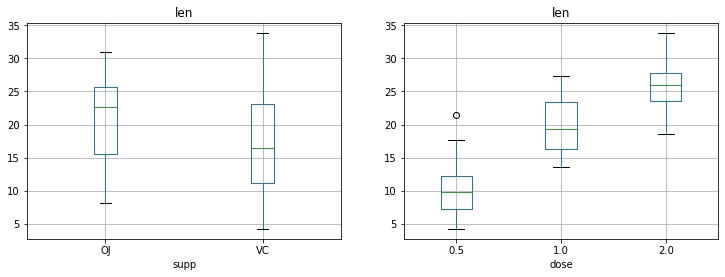

In [10]:
fig, axs = plt.subplots(ncols=2, figsize=(12, 4))
df2.boxplot('len', by='supp', figsize=(6, 4), ax=axs[0])
df2.boxplot('len', by='dose', figsize=(6, 4), ax=axs[1])
fig.suptitle('');

We can use `statsmodels`'s interaction plot to see if checking for an interaction is justified (it almost always is.)

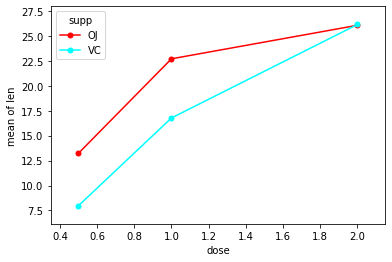

In [11]:
interaction_plot(df2['dose'], df2['supp'], df2['len'],ms=10);

Now we specify and fit the model, including an interaction term between 'supp' and 'dose'

In [12]:
relationship = 'len ~ C(supp) + C(dose) + C(supp):C(dose)'  # Specify the relationships

model2 = ols(relationship, df2).fit()                       # Specify and fit the linear model

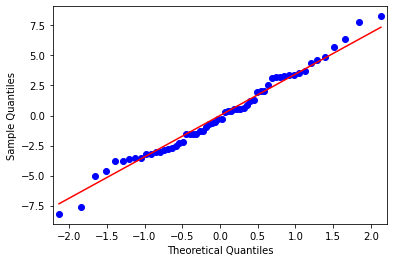

In [13]:
# We can check to see how the ols fit went using a statsmodels q-q plot

sm.qqplot(model2.resid, line='s');

In [14]:
# Finally we run the ANOVA

anova2 = sm.stats.anova_lm(model2, typ=2)
anova2

,sum_sq,df,F,PR(>F)
C(supp),205.350000,1.0,15.571979,2.311828e-04
C(dose),2426.434333,2.0,91.999965,4.046291e-18
C(supp):C(dose),108.319000,2.0,4.106991,2.186027e-02
Residual,712.106000,54.0,NaN,NaN


We can calculate eta squared (uncorrected effect size estimate) and omega squared (a less biased version of eta squared) values ourselves:

In [15]:
anova2['eta_squared'] = anova2[:-1]['sum_sq']/sum(anova2['sum_sq'])

mse = anova2['sum_sq'][-1]/anova2['df'][-1]
anova2['omega_sq'] = (anova2[:-1]['sum_sq']-(anova2[:-1]['df']*mse)) / (sum(anova2['sum_sq'])+mse)

anova2

,sum_sq,df,F,PR(>F),eta_squared,omega_sq
C(supp),205.350000,1.0,15.571979,2.311828e-04,0.059484,0.055452
C(dose),2426.434333,2.0,91.999965,4.046291e-18,0.702864,0.692579
C(supp):C(dose),108.319000,2.0,4.106991,2.186027e-02,0.031377,0.023647
Residual,712.106000,54.0,NaN,NaN,NaN,NaN


And we do pairwise comparisons to discover where the differences come from (as for the one-way above).

In [16]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

print(pairwise_tukeyhsd(endog=df2['len'], groups=df2['dose'], alpha=0.05))
print()
print(pairwise_tukeyhsd(endog=df2['len'], groups=df2['supp'], alpha=0.05))

Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj  lower   upper  reject
---------------------------------------------------
   0.5    1.0     9.13 0.001  5.9018 12.3582   True
   0.5    2.0   15.495 0.001 12.2668 18.7232   True
   1.0    2.0    6.365 0.001  3.1368  9.5932   True
---------------------------------------------------

Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj  lower  upper reject
-------------------------------------------------
    OJ     VC     -3.7 0.0604 -7.567 0.167  False
-------------------------------------------------
